In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax 
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import trange


key = jr.key(0)

In [2]:
def get_dataset(key, n_data, max_length=10):
    x = jr.randint(key, (n_data, max_length), 1, 100) 
    y = jnp.max(x, axis=1)
    x, y = np.expand_dims(x, axis=2), np.expand_dims(y, axis=1)
    return x, y

X, Y = get_dataset(key, 50_000)
X.shape, Y.shape

((50000, 10, 1), (50000, 1))

In [3]:
from typing import List
from model import MultiheadAttentionPooling, SelfAttentionBlock

class SmallSetTransformer(eqx.Module):
    blocks: List[SelfAttentionBlock]
    pooling: MultiheadAttentionPooling
    out: eqx.nn.Linear

    def __init__(self, *, key):
        keys = jr.split(key, 4)
        # Encoder
        self.blocks = [
            SelfAttentionBlock(
                in_size=1, out_size=64, n_heads=4, hidden_dim=64, key=keys[0]
            ),
            SelfAttentionBlock(
                in_size=64, out_size=64, n_heads=4, hidden_dim=64, key=keys[1]
            )
        ]
        # Decoder 
        self.pooling = MultiheadAttentionPooling(
            in_size=64, n_heads=4, n_seeds=1, hidden_dim=64, key=keys[2]
        )
        self.out = eqx.nn.Linear(in_features=64, out_features=1, key=keys[3])

    def __call__(self, x):
        for b in self.blocks:
            x = b(x)
        x = self.pooling(x)
        x = jax.vmap(self.out)(x)
        return x.squeeze(-1)

In [4]:
model = SmallSetTransformer(key=key)
jax.vmap(model)(X[:5]).shape

(5, 1)

In [5]:
f = 0.8
Xt, Xv = np.split(X, [int(f * len(X))])
Yt, Yv = np.split(Y, [int(f * len(X))])

set_ds_train = torch.utils.data.TensorDataset(
    torch.as_tensor(Xt), torch.as_tensor(Yt)
)
set_ds_valid = torch.utils.data.TensorDataset(
    torch.as_tensor(Xv), torch.as_tensor(Yv)
)

/var/folders/8t/4ygzv0nj53sdbz0dz587zwzh0000gq/T/ipykernel_79605/2141409469.py:6: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  torch.as_tensor(Xt), torch.as_tensor(Yt)


In [6]:
n_epochs = 500
n_batch = 2000
opt = optax.adam(learning_rate=1e-3)

n_data, n_set, data_dim = X.shape

model = SmallSetTransformer(key=key)

opt_state = opt.init(eqx.filter(model, eqx.is_array))


def loss(model, x, y):
    y_ = jax.vmap(model)(x)
    # return optax.l2_loss(y_, y).mean()
    return jnp.abs(y - y_).mean()


@eqx.filter_jit
def make_step(model, opt_state, x, y):
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
    updates, opt_state = opt.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value


@eqx.filter_jit
def eval(model, x, y):
    loss_value = loss(model, x, y)
    return loss_value


def prepare(x, y):
    return x.numpy(), y.numpy()


losses = []
with trange(n_epochs) as bar:
    set_dl_train = torch.utils.data.DataLoader(set_ds_train, batch_size=n_batch)
    set_dl_valid = torch.utils.data.DataLoader(set_ds_valid, batch_size=n_batch)

    for _ in bar:
        Lt = 0.
        for t, (x, y) in enumerate(set_dl_train):
            x, y = prepare(x, y)
            model, opt_state, _Lt = make_step(model, opt_state, x, y)
            Lt += _Lt

        Lv = 0.
        for v, (x, y) in enumerate(set_dl_valid):
            x, y = prepare(x, y)
            _Lv = eval(model, x, y)
            Lv += _Lv
        
        Lt = Lt.item() / (t + 1) 
        Lv = Lv.item() / (v + 1)
        losses.append((Lt, Lv))
        bar.set_postfix_str(f"{Lt=:.3E} {Lv=:.3E}")

  0%|          | 0/500 [00:00<?, ?it/s]

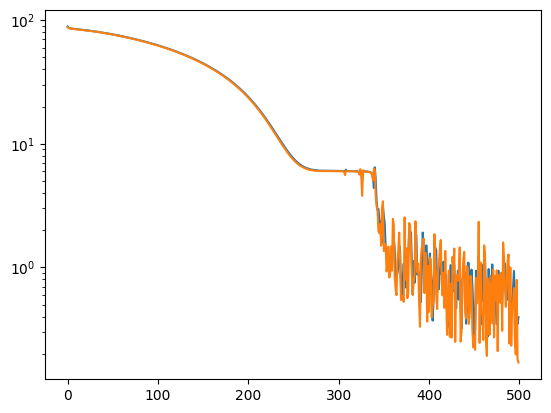

In [7]:
plt.semilogy(losses)
plt.show()

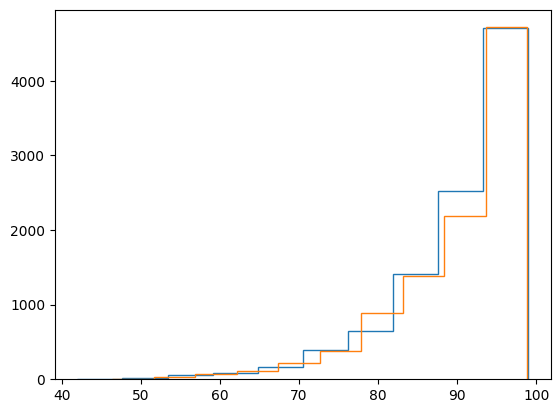

In [21]:
ix = jr.randint(key, (10_000,), 0, n_data)
x, y = X[ix], Y[ix]
y_ = jax.vmap(model)(x).squeeze()
x = x.squeeze().max(axis=1)

plt.figure()
plt.hist(x, histtype="step")
plt.hist(y_, histtype="step")
plt.show()